## Vehicle Detection


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Import Packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import sys, os, time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

## Initialization

In [28]:
global show_debug_info
show_debug_info = True

param_hog = {'orient': 9, 'ppc': 8, 'cpb': 2, 'channel': 0}
param_spatial_bin = {'color': 'LUV', 'size': (16, 16)}

# y_range = [[[0, 1280], [400, 650]]]
# xy_windows_multi_scale = [(128, 128)]

y_range = [[[20, 600], [400, 650]],
           [[680, 1260], [400, 650]],
           [[480, 800], [400, 560]]]
xy_windows_multi_scale = [(90, 90),
                          (90, 90),
                          (128, 128)]

In [11]:
# Extract HoG
def get_hog_feature(img, orient, ppc, cpb, vis=True, feature_vec=True):
    return_list = hog(img, orientations=orient, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb),
                      block_norm='L2', transform_sqrt=False, visualise=vis, feature_vector=feature_vec)

    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        hog_features = return_list
        return hog_features

# Extract spatial bins
def bin_spatial(img, color_space='RGB', size=(32, 32)):  
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

    
# Extract features
def FeatureExtraction(img, hog_params, bin_spatial_params):
    # convert color    
    color_space = bin_spatial_params['color']
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: img = np.copy(img)  

    # hog
    channel = hog_params['channel']
    f_hog = []
    if channel == 'ALL':
        fs_hog = []
        for c in range(img.shape[2]):
            f_hog, img_hog = get_hog_feature(img[:,:,c], hog_params['orient'], hog_params['ppc'], hog_params['cpb'])
            fs_hog.append(f_hog)
        f_hog = np.ravel(fs_hog)  
    else:
        f_hog, img_hog = get_hog_feature(img[:,:,channel], hog_params['orient'], hog_params['ppc'], hog_params['cpb'])

    # 'HSV', size=(16, 16)
    f_spatial = bin_spatial(img, bin_spatial_params['color'], size=bin_spatial_params['size'])

    hist_color = color_hist(img)
    
    features = []
    features.append(f_hog)
    features.append(f_spatial)
    features.append(hist_color)
    return np.concatenate(features)

#     features = np.concatenate((f_hog, f_spatial, hist_color))
#     return features

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def FindCarCandidates(img, windows, clf, scaler):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
#         print(window)
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        
        features = FeatureExtraction(test_img, param_hog, param_spatial_bin)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
#             print('matched!')
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:
# Use heat map to filter out obejct suddenly appear
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [14]:
def Process(image, fg_ret_heatmap=False):
    # Input: RGB image
    
    # multi scale windows
    windows_multi_scale = []
    for i in range(len(y_range)):
        windows = slide_window(image, x_start_stop=y_range[i][0], y_start_stop=y_range[i][1], 
                            xy_window=xy_windows_multi_scale[i], xy_overlap=(0.5, 0.5))
#         print(len(windows))
        windows_multi_scale += windows
#         print(len(windows_multi_scale))

    global X_scaler
    hot_windows = FindCarCandidates(image, windows_multi_scale, svc, X_scaler)
    
    # a. no heatmap
    window_img_a = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # b. no heatmap
    window_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # debug
    if show_debug_info:
        fig = plt.figure()
        plt.subplot(141)
        plt.imshow(window_img)
        plt.title('Car Positions')
        plt.subplot(142)
        plt.imshow(window_img_a)
        plt.title('Detected Objects')
        plt.subplot(143)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(144)
        plt.imshow(window_img)
        plt.title('Filtered Objects')
        fig.tight_layout()

    if fg_ret_heatmap is True:
        return window_img, heatmap, window_img_a
    else:
        return window_img

## Load Dataset

In [15]:
img_filename_v = glob.glob('./dataset/vehicles/**/*.png')
img_filename_nv = glob.glob('./dataset/non-vehicles/**/*.png')
print('Dataset size of vehicel:', len(img_filename_v))
print('Dataset size of non-vehicel:', len(img_filename_nv))

Dataset size of vehicel: 8792
Dataset size of non-vehicel: 8968


In [16]:
features_v = []
features_nv = []
X_train = []
X_test = []
y_train = []
y_test = []

print('Vehicle')
for filename in img_filename_v:
#     print(filename)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = FeatureExtraction(img, param_hog, param_spatial_bin)
    features_v.append(features)
    
print('Non-vehicle')
for filename in img_filename_nv:
#     print(filename)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features = FeatureExtraction(img, param_hog, param_spatial_bin)
    features_nv.append(features)
    
print('Feature vector length:', len(features_v[0]))
X = np.vstack((features_v, features_nv)).astype(np.float64)
y = np.hstack((np.ones(len(features_v)), np.zeros(len(features_nv))))

# Default shuffle data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Amount:\n", "\tTraining dataset:", len(X_train), "\n\tTest dataset:", len(X_test))

Vehicle
Non-vehicle
Feature vector length: 2628
Amount:
 	Training dataset: 14208 
	Test dataset: 3552


## Train

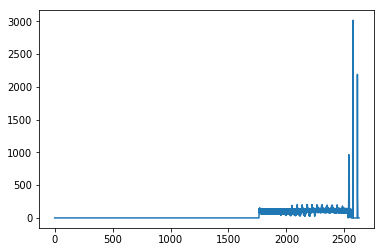

5.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts:	 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
For these 10 labels:	 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
0.00143 Seconds to predict 10 labels with SVC.


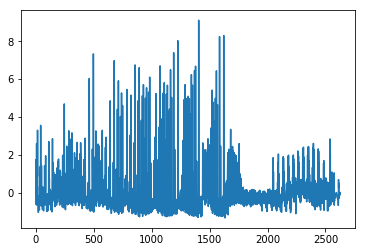

In [17]:
# Fit a per-column scaler only on the training data
global X_scaler
plt.show()
plt.plot(X_train[0])
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
plt.show()
plt.plot(X_train[0])

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:\t', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC.')

## Test

./test_images/t/frame282.jpg
./test_images/t/frame450.jpg
./test_images/t/frame537.jpg
./test_images/t/frame566.jpg
./test_images/t/frame618.jpg
./test_images/t/frame710.jpg
./test_images/t/frame766.jpg
./test_images/t/frame898.jpg
./test_images/t/frame926.jpg
./test_images/t/frame966.jpg


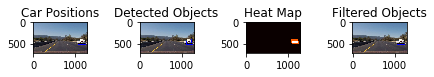

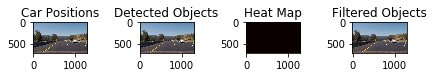

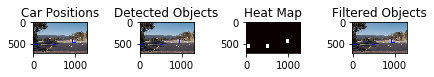

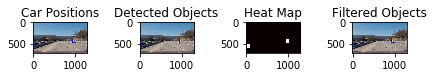

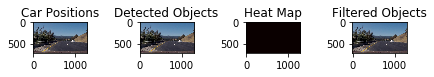

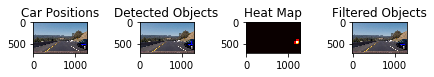

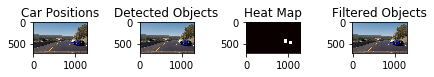

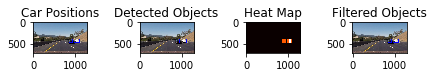

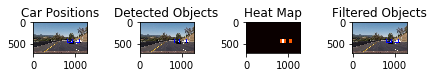

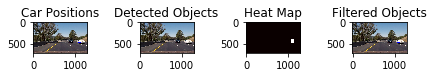

In [18]:
test_imgs = sorted(glob.glob('./test_images/t/*.jpg'))

for img in test_imgs:
    print(img)
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    window_img, heatmap, window_img_a = Process(img, fg_ret_heatmap=True)

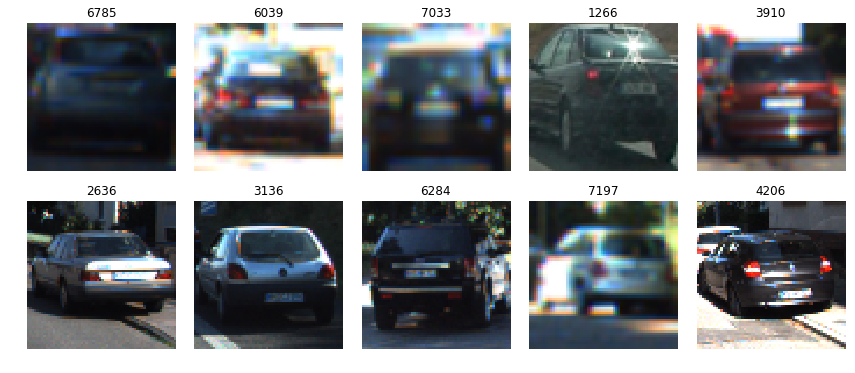

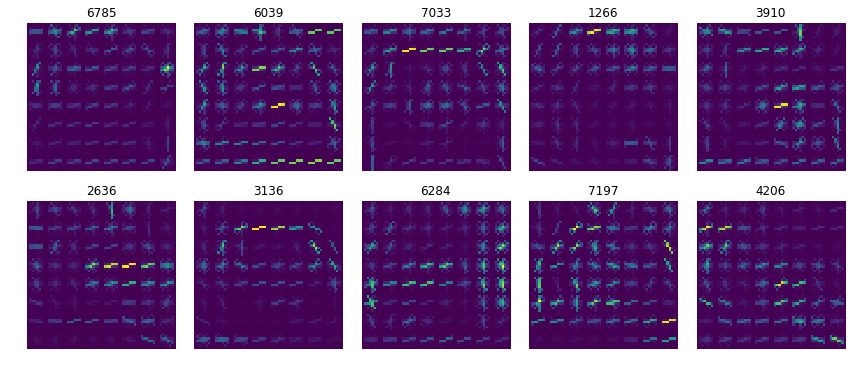

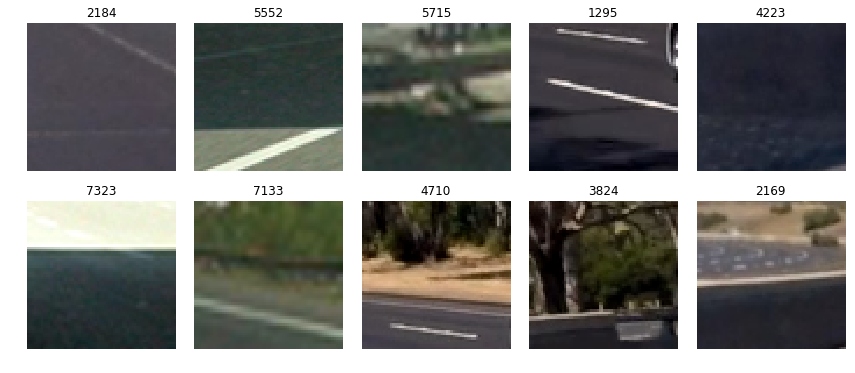

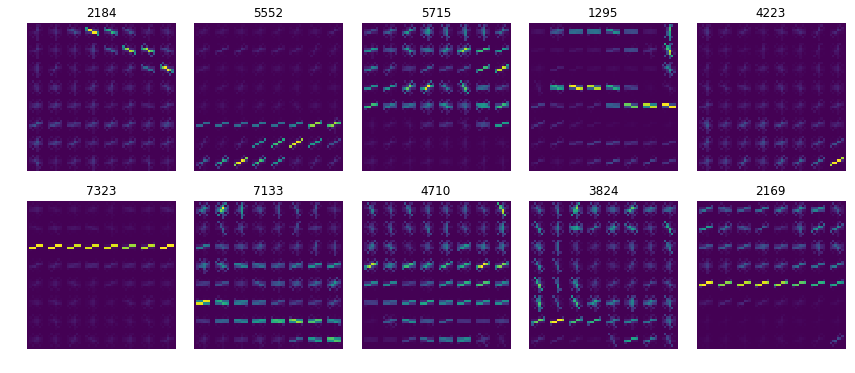

In [19]:
# show image of 10 random data points
row = 2
col = 5
num = row * col
index = np.random.randint(0, high=len(img_filename_v), size=num)
fig, axs = plt.subplots(row, col, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(num):
    image = cv2.imread(img_filename_v[index[i]])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(index[i])
plt.show()
#hog
fig, axs = plt.subplots(row, col, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(num):
    image = cv2.imread(img_filename_v[index[i]])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, img_hog = get_hog_feature(image, 9, 8, 2)
    axs[i].axis('off')
    axs[i].imshow(img_hog)
    axs[i].set_title(index[i])
plt.show()

print()
index = np.random.randint(0, high=len(img_filename_nv), size=num)
fig, axs = plt.subplots(row, col, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(num):
    image = cv2.imread(img_filename_nv[index[i]])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(index[i])
plt.show()
#hog
fig, axs = plt.subplots(row, col, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(num):
    image = cv2.imread(img_filename_nv[index[i]])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, img_hog = get_hog_feature(image, 9, 8, 2)
    axs[i].axis('off')
    axs[i].imshow(img_hog)
    axs[i].set_title(index[i])
plt.show()

---
## Video Part

In [29]:
show_debug_info = False

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
output_dir = 'test_videos_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [32]:
video_name = 'test_video.mp4'
white_output = output_dir + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./" + video_name)
white_clip = clip1.fl_image(Process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4



 97%|█████████▋| 38/39 [00:52<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 52.6 s, sys: 229 ms, total: 52.8 s
Wall time: 54 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [34]:
video_name = 'project_video.mp4'
white_output = output_dir + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./" + video_name)
white_clip = clip1.fl_image(Process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 12%|█▏        | 152/1261 [03:32<24:43,  1.34s/it]


 24%|██▍       | 303/1261 [06:59<23:01,  1.44s/it]


 36%|███▌      | 454/1261 [10:34<18:40,  1.39s/it]


 48%|████▊     | 605/1261 [14:04<16:31,  1.51s/it]


 60%|█████▉    | 756/1261 [17:42<11:48,  1.40s/it]


 72%|███████▏  | 907/1261 [21:17<07:55,  1.34s/it]


 84%|████████▍ | 1057/1261 [24:42<04:52,  1.43s/it]


 96%|█████████▌| 1205/1261 [28:07<01:15,  1.34s/it]


100%|█████████▉| 1260/1261 [29:22<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 29min 13s, sys: 6.69 s, total: 29min 20s
Wall time: 29min 22s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))